In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

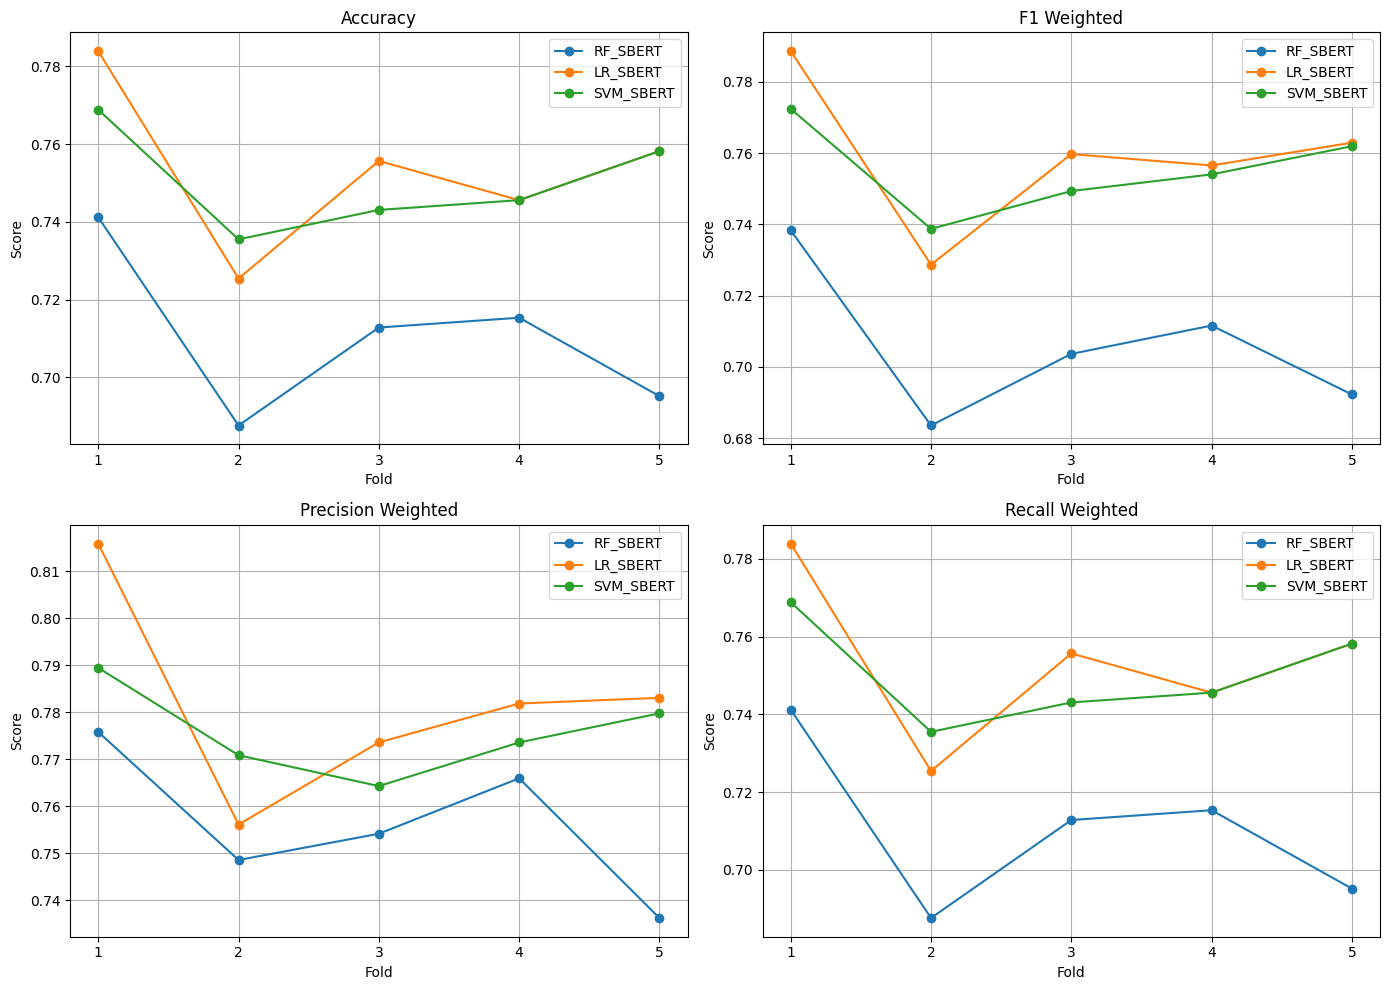

In [2]:
# Load model evaluation results from JSON file
with open('classifierEvaluation.json', 'r') as f:
    results = json.load(f)

# Extract test scores per metric for each model
model_metrics = {}
for model_key, model_data in results.items():
    model_metrics[model_key] = {}
    metrics = model_data['metrics']
    for metric_name, metric_data in metrics.items():
        # Get the list of scores for each fold in the test phase
        model_metrics[model_key][metric_name] = metric_data['test']['folds']

# List of metrics to visualize
metrics_list = ["accuracy", "f1_weighted", "precision_weighted", "recall_weighted"]

# === Line Plot per Fold ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics_list):
    ax = axes[i]
    for model_key in model_metrics:
        scores = model_metrics[model_key][metric]
        ax.plot(
            range(1, len(scores) + 1),
            scores,
            marker='o',
            label=model_key
        )
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xlabel('Fold')
    ax.set_ylabel('Score')
    ax.set_xticks(range(1, len(scores) + 1))
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

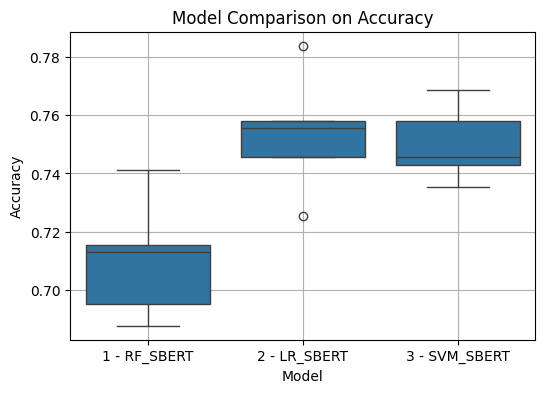

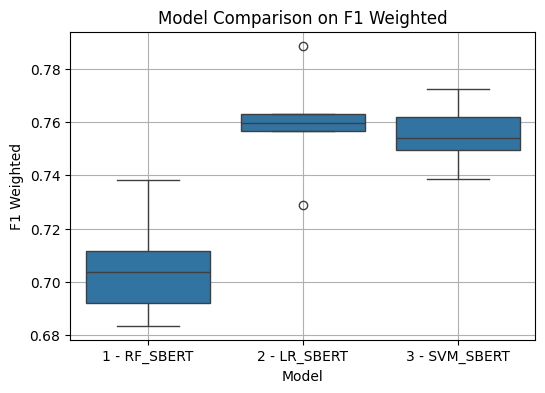

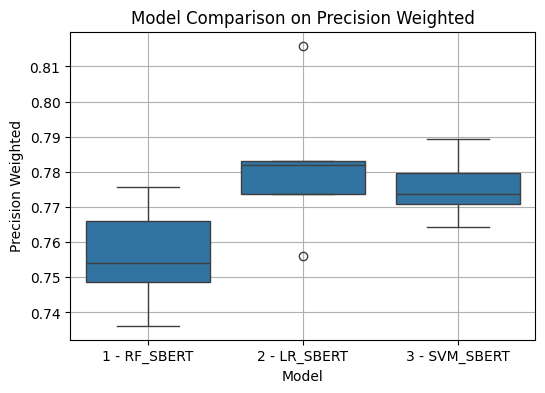

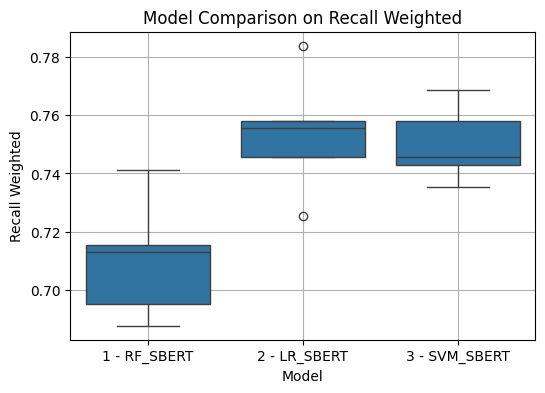

In [3]:
model_names = list(results.keys())

for metric in metrics_list:
    # Prepare a long-format DataFrame for seaborn boxplot
    plot_data = []
    for i, model in enumerate(model_names):
        label = f'{i+1} - {model}'
        fold_scores = results[model]["metrics"][metric]["test"]["folds"]
        for value in fold_scores:
            plot_data.append({"Model": label, metric: value})

    df_long = pd.DataFrame(plot_data)
    
    plt.figure(figsize=(max(6, len(model_names) * 2), 4))
    ax = sns.boxplot(x="Model", y=metric, data=df_long)
    ax.set_ylabel(metric.replace("_", " ").title())
    ax.set_xlabel("Model")
    plt.title(f'Model Comparison on {metric.replace("_", " ").title()}')
    plt.grid(True)
    plt.show()


In [4]:
train_path = "PreProcessingResumes/processed_data/Resume/train.csv"  
test_path = "PreProcessingResumes/processed_data/Resume/test.csv"    

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [5]:
encoder = LabelEncoder()
encoder.fit(train_df['Category'])

X_train = train_df['Resume_str'].tolist()
y_train = encoder.transform(train_df['Category'])

X_test = test_df['Resume_str'].tolist()
y_test = encoder.transform(test_df['Category'])

In [6]:
# Load the SBERT model for generating sentence embeddings
sbert_model = SentenceTransformer('all-MiniLM-L12-v2')

In [7]:
# Generate SBERT embeddings
X_train_embed = sbert_model.encode(X_train, show_progress_bar=True)
X_test_embed = sbert_model.encode(X_test, show_progress_bar=True)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [8]:
class_counts = train_df['Category'].value_counts()
min_classes = class_counts[class_counts < 0.75*class_counts.mean()].index.tolist()

print(f"Applying SMOTE to classes: {min_classes}")

target_size = int(0.75*class_counts.max())

min_classes_encoded = encoder.transform(min_classes)
sampling_strategy = {label: target_size for label in min_classes_encoded}

Applying SMOTE to classes: ['ADVOCATE', 'APPAREL', 'BPO', 'AGRICULTURE', 'ARTS', 'AUTOMOBILE']


In [9]:
with open('classifierEvaluation.json', 'r') as f:
    model_configs = json.load(f)

def get_model_class(key_name):
    if key_name.startswith("RF"):
        return RandomForestClassifier
    elif key_name.startswith("LR"):
        return LogisticRegression
    elif key_name.startswith("SVM"):
        return SVC
    else:
        raise ValueError(f"Unknown model prefix in key: {key_name}")

selected_model_key = "LR_SBERT"

config = model_configs[selected_model_key]
raw_params = config["params"]
model_params = {k.replace("clf__", ""): v for k, v in raw_params.items()}

ModelClass = get_model_class(selected_model_key)

model = ModelClass(**model_params)

In [10]:
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=4)),
    ('clf', model)
])

In [11]:
pipeline.fit(X_train_embed, y_train)

Pipeline(steps=[('smote',
                 SMOTE(k_neighbors=4, random_state=42,
                       sampling_strategy={1: 103, 2: 103, 3: 103, 4: 103,
                                          5: 103, 8: 103})),
                ('clf', LogisticRegression(C=1))])

In [12]:
y_train_pred = pipeline.predict(X_train_embed)
y_test_pred = pipeline.predict(X_test_embed)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Train Accuracy: 0.8223
Test Accuracy: 0.7686


In [13]:
print(classification_report(y_test, y_test_pred, target_names=encoder.classes_, zero_division=0))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.90      0.96      0.93        28
              ADVOCATE       0.50      0.77      0.61        13
           AGRICULTURE       1.00      0.67      0.80         6
               APPAREL       0.73      0.73      0.73        11
                  ARTS       1.00      0.60      0.75         5
            AUTOMOBILE       0.00      0.00      0.00         2
              AVIATION       0.74      0.74      0.74        19
               BANKING       0.86      0.35      0.50        17
                   BPO       0.30      0.60      0.40        10
  BUSINESS-DEVELOPMENT       0.82      0.66      0.73        35
                  CHEF       0.90      0.95      0.93        20
          CONSTRUCTION       0.95      0.86      0.90        22
            CONSULTANT       0.69      0.83      0.75        24
              DESIGNER       0.87      0.91      0.89        22
         DIGITAL-MEDIA       0.65      

<Figure size 1500x1000 with 0 Axes>

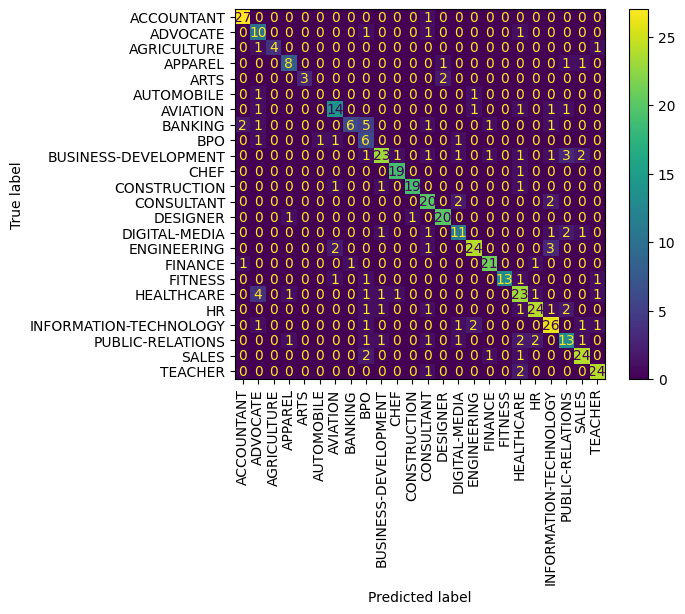

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    display_labels=encoder.classes_
)
plt.xticks(rotation=90)
plt.show()

In [15]:
# Save the trained pipeline (SMOTE + classifier)
joblib.dump(pipeline, 'Models/lr_sbert_pipeline.joblib')

# (Opzionale) salva anche l’encoder delle label per future inverse-transform
joblib.dump(encoder, 'Models/label_encoder.joblib')

print("Models saved")

Models saved
